# Transfer learning with TensorFlow part 3: Scaling up (food vision mini)

In [1]:
!nvidia-smi

Thu Jun  9 23:28:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created a series of helper functions to do certain tasks, let's download them

In [2]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2022-06-09 23:28:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-09 23:28:57 (75.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the data 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-06-09 23:29:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   193MB/s    in 7.7s    

2022-06-09 23:29:09 (200 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
# How many images/classes are ther
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_all_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientB0 backboned-model
* Compile our model
* Feature extract for 5 epochs on the train dataset and validate on 15% of the test data

In [9]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [10]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  #preprocessing.Rescaling(1/255.) # Not required for efficientNet
], name="data_augmentation")

In [11]:
# Create a base model and freeze its layers
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224, 3), name="input_layer")
x = data_augmentation(inputs) # augment_images

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="average_pooling_layer")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_10_percent = model.fit(train_data_all_10,
                               epochs=5,
                               steps_per_epoch=len(train_data_all_10),
                               validation_data=test_data,
                               validation_steps=int(0.15*len(test_data)),
                               callbacks=[create_tensorboard_callback("food101_experiments", "10_percent_aug"), checkpoint_callback])

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: food101_experiments/10_percent_aug/20220609-232937
Epoch 1/5
237/237 [==============================] - 96s 332ms/step - loss: 3.4508 - accuracy: 0.2490 - val_loss: 2.6133 - val_accuracy: 0.4338
Epoch 2/5
237/237 [==============================] - 62s 258ms/step - loss: 2.3498 - accuracy: 0.4627 - val_loss: 2.1959 - val_accuracy: 0.4823
Epoch 3/5
237/237 [==============================] - 57s 240ms/step - loss: 1.9840 - accuracy: 0.5278 - val_loss: 1.9830 - val_accuracy: 0.5085
Epoch 4/5
237/237 [==============================] - 52s 215ms/step - loss: 1.7564 - accuracy: 0.5787 - val_loss: 1.9647 - val_accuracy: 0.5019
Epoch 5/5
237/237 [==============================] - 50s 208ms/step - loss: 1.6055 - accuracy: 0.6084 - val_loss: 1.8844 - val_accuracy: 0.5093


In [12]:
# Evaluate the model
feature_extraction_results  = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 58s 73ms/step - loss: 1.7200 - accuracy: 0.5504


[1.7199891805648804, 0.5504158139228821]

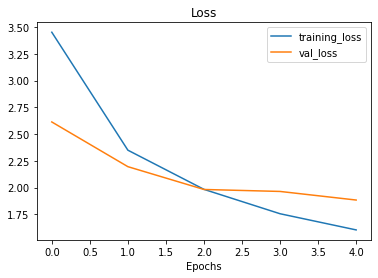

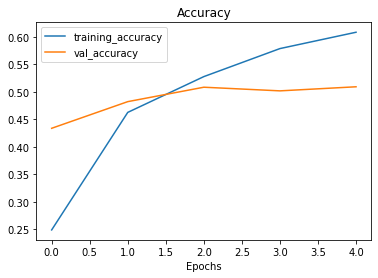

In [13]:
plot_loss_curves(history_10_percent)

We can see that our model is overfitting because the validation curve is moving away from the training curve

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [16]:
# Recompile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# Fit the model
history_10_percent_fine_tuned = model.fit(train_data_all_10,
                                          epochs=10,
                                          initial_epoch=history_10_percent.epoch[-1],
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          callbacks=[create_tensorboard_callback("food101_experiments", "10_percent_aug_fine_tuned")])

Saving TensorBoard log files to: food101_experiments/10_percent_aug_fine_tuned/20220609-233646
Epoch 5/10
237/237 [==============================] - 57s 210ms/step - loss: 1.3580 - accuracy: 0.6479 - val_loss: 1.8771 - val_accuracy: 0.5072
Epoch 6/10
237/237 [==============================] - 46s 192ms/step - loss: 1.2367 - accuracy: 0.6733 - val_loss: 1.8897 - val_accuracy: 0.5109
Epoch 7/10
237/237 [==============================] - 44s 182ms/step - loss: 1.1631 - accuracy: 0.6867 - val_loss: 1.8568 - val_accuracy: 0.5162
Epoch 8/10
237/237 [==============================] - 43s 178ms/step - loss: 1.0796 - accuracy: 0.7119 - val_loss: 1.8233 - val_accuracy: 0.5289
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.0293 - accuracy: 0.7258 - val_loss: 1.8172 - val_accuracy: 0.5294
Epoch 10/10
237/237 [==============================] - 42s 178ms/step - loss: 0.9733 - accuracy: 0.7450 - val_loss: 1.7938 - val_accuracy: 0.5342


In [17]:
# Evaluate on the test data
fine_tuned_results_2 = model.evaluate(test_data)
fine_tuned_results_2

790/790 [==============================] - 57s 72ms/step - loss: 1.6150 - accuracy: 0.5769


[1.615020990371704, 0.5768712759017944]

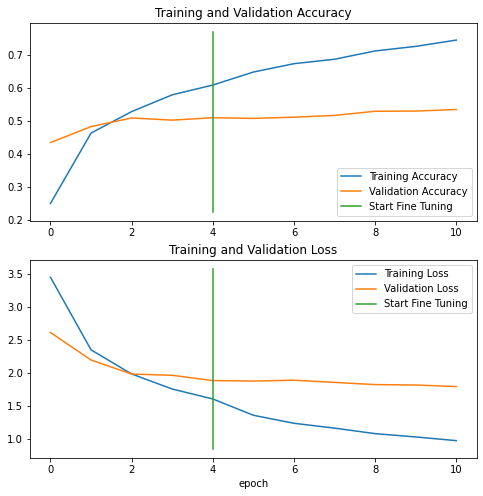

In [18]:
# Compare the history
compare_historys(history_10_percent, history_10_percent_fine_tuned, 5)

## Saving and loading our mode

To use our model in an external application, we need to save it and export it somewhere

In [19]:
# Save our fine-tuned model
model.save("drive/MyDrive/TensorFlow/101_food_classes_10_percent")

INFO:tensorflow:Assets written to: drive/MyDrive/TensorFlow/101_food_classes_10_percent/assets


In [20]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/TensorFlow/101_food_classes_10_percent")

In [21]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 60s 74ms/step - loss: 1.6150 - accuracy: 0.5769


[1.615020990371704, 0.5768712759017944]

In [22]:
fine_tuned_results_2

[1.615020990371704, 0.5768712759017944]

## Evaluating the performance of our model accross all different classes

Let's make some predictions, visualize them and find out which prediction are the most wrong

In [23]:
import tensorflow as tf
# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-09 23:45:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  93.1MB/s    in 0.5s    

2022-06-09 23:45:24 (93.1 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [24]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [25]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [26]:
model.evaluate(test_data)

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Make predictions with our trained model

In [27]:
# Make predictions with our model
pred_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 [==============================] - 63s 78ms/step


In [28]:
pred_probs

array([[5.95419966e-02, 3.57420436e-06, 4.13770080e-02, ...,
        1.41386791e-09, 8.35308238e-05, 3.08975088e-03],
       [9.64016795e-01, 1.37532719e-09, 8.47808202e-04, ...,
        5.42870475e-05, 7.83622039e-12, 9.84660242e-10],
       [9.59258676e-01, 3.25336478e-05, 1.48669630e-03, ...,
        7.18912702e-07, 5.43972646e-07, 4.02759251e-05],
       ...,
       [1.51387176e-05, 4.09728906e-04, 8.02506672e-10, ...,
        2.17429060e-05, 1.07972191e-05, 5.37898898e-01],
       [5.93182212e-03, 4.92367381e-03, 9.98234656e-03, ...,
        1.19895354e-04, 1.68903825e-05, 4.52181026e-02],
       [3.13634649e-02, 7.50526646e-03, 4.29749402e-04, ...,
        5.03465941e-04, 5.20561434e-06, 6.90628111e-01]], dtype=float32)

In [29]:
# Let's what the first 10 predictions look like
pred_probs[4]

array([1.71047717e-01, 2.22728747e-09, 2.33601287e-01, 1.71237904e-08,
       2.22244134e-09, 2.31358558e-06, 1.06949728e-05, 2.18119396e-07,
       5.25441719e-04, 1.49036023e-05, 1.65661447e-06, 3.90535433e-06,
       3.78888508e-05, 6.97065019e-08, 2.05922785e-04, 5.36104853e-05,
       5.73413272e-09, 2.38556677e-05, 1.72382759e-04, 3.29038221e-06,
       1.30906335e-06, 4.24292084e-05, 6.98062300e-04, 1.08462039e-08,
       8.70064853e-10, 1.90620142e-07, 1.45091355e-04, 5.28595046e-06,
       1.94364420e-05, 3.10849044e-02, 4.09189171e-09, 1.01619198e-05,
       1.83669420e-06, 5.38683681e-11, 9.31957220e-06, 2.60847310e-06,
       5.84415720e-05, 7.56368026e-05, 4.99683885e-08, 5.10073714e-02,
       4.93246015e-13, 9.61604837e-06, 2.21843095e-07, 1.56579572e-09,
       1.62870833e-06, 6.49291323e-08, 1.98543043e-10, 8.31267499e-10,
       4.71192934e-08, 3.74374167e-06, 3.02937551e-04, 1.14094661e-07,
       2.15927299e-04, 6.75218704e-04, 5.94553642e-11, 4.69144754e-04,
      

In [30]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"Probabilities for sample 0: {pred_probs[0]}")
print(f"Predictied class for sample 0: {pred_probs[0].argmax()}")
print(f"Predicted class: {train_data_all_10.class_names[pred_probs[0].argmax()]}")

Number of prediction probabilities for sample 0: 101
Probabilities for sample 0: [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 1.0569904e-06 2.1293351e

In [31]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Now we've got predictions array of all of our model's predictions we need to evaluate them

In [32]:
# Get the labels of test_data
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently the labels are on hot encoded so we do argmax
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
# How many y labels are there
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order to find the accuracy score

In [34]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_labels, pred_classes)
acc

0.6077623762376237

## Let's make a confusion matrix

In [35]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

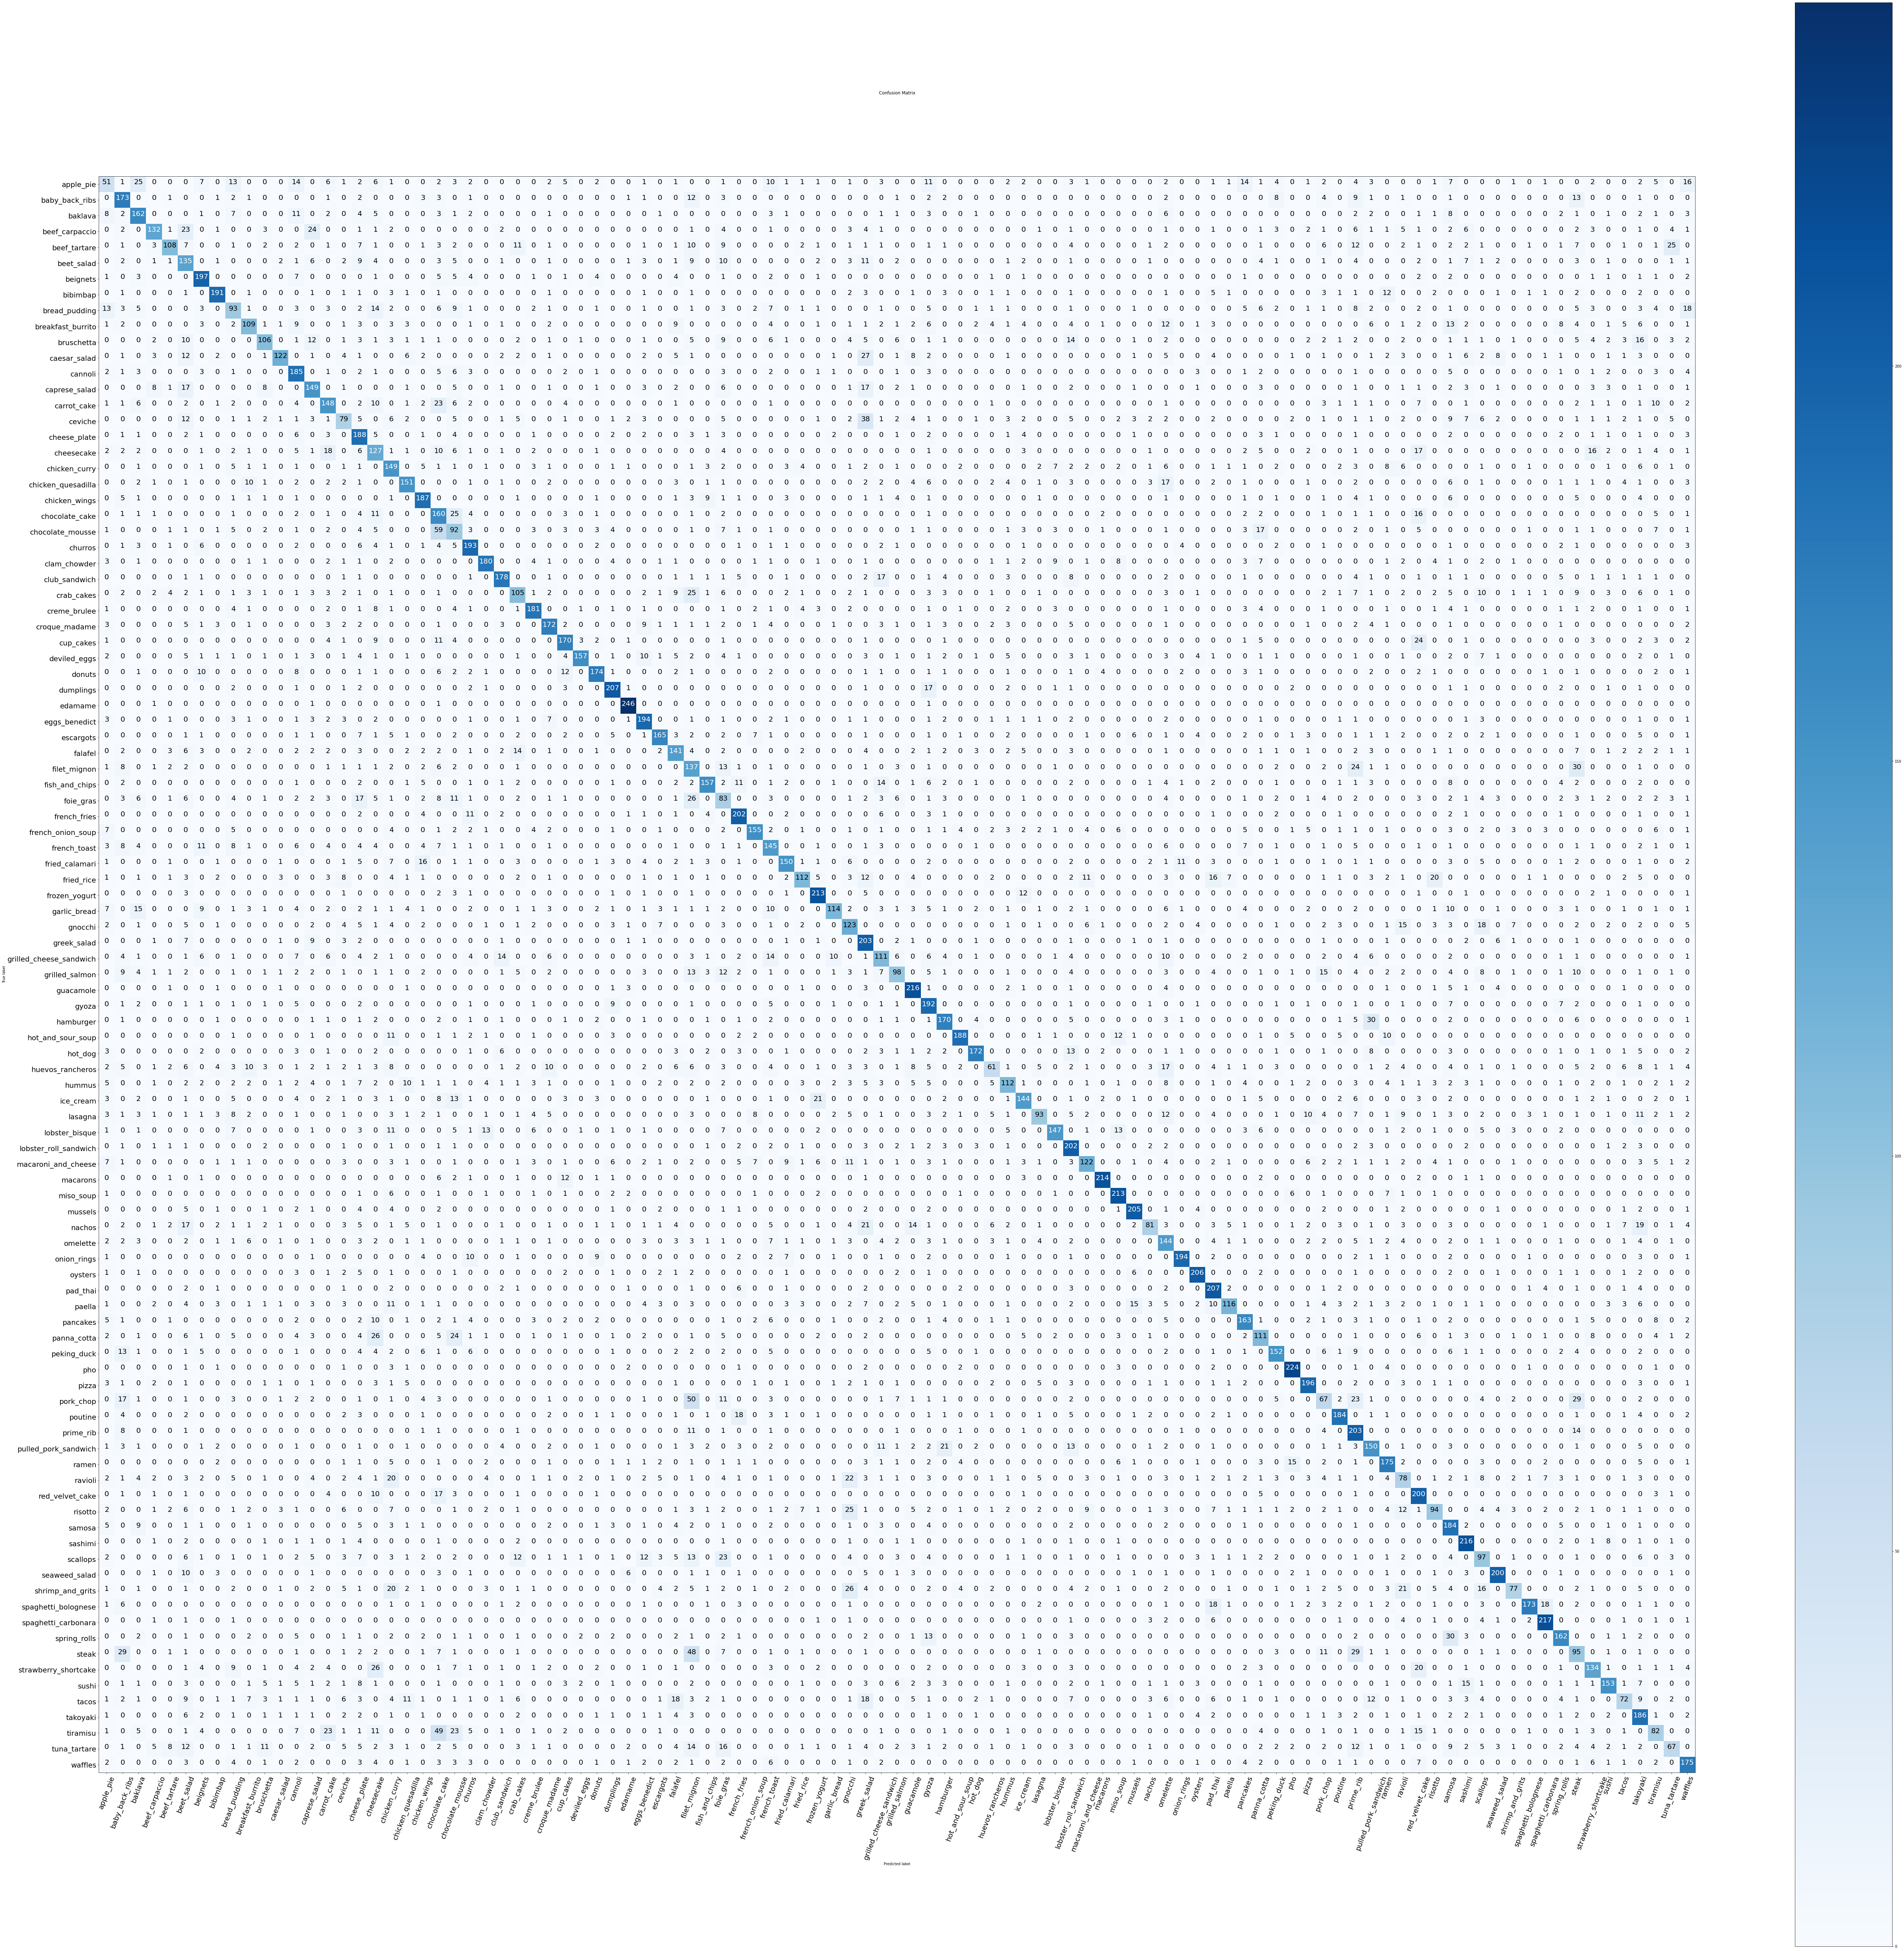

In [36]:
make_confusion_matrix(y_labels, pred_classes, train_data_all_10.class_names, figsize=(100, 100), text_size=20, savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring classification report

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [38]:
# Get a dictionnary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [39]:
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [40]:
class_names = train_data_all_10.class_names

In [41]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores

In [42]:
# Create an empty dictionnary
class_f1_scores = {}
#Loop through classification report dictionnary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get the accuracy key
    break
  else:
    # Add class names and f1-score to empty dictionnary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [43]:
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [44]:
# Turn f1-scores into dataframe
import pandas as pd
f1_scores = pd.DataFrame({
    "class_names": list(class_f1_scores.keys()),
    "f1-score": list(class_f1_scores.values())
    }).sort_values("f1-score", ascending=False)

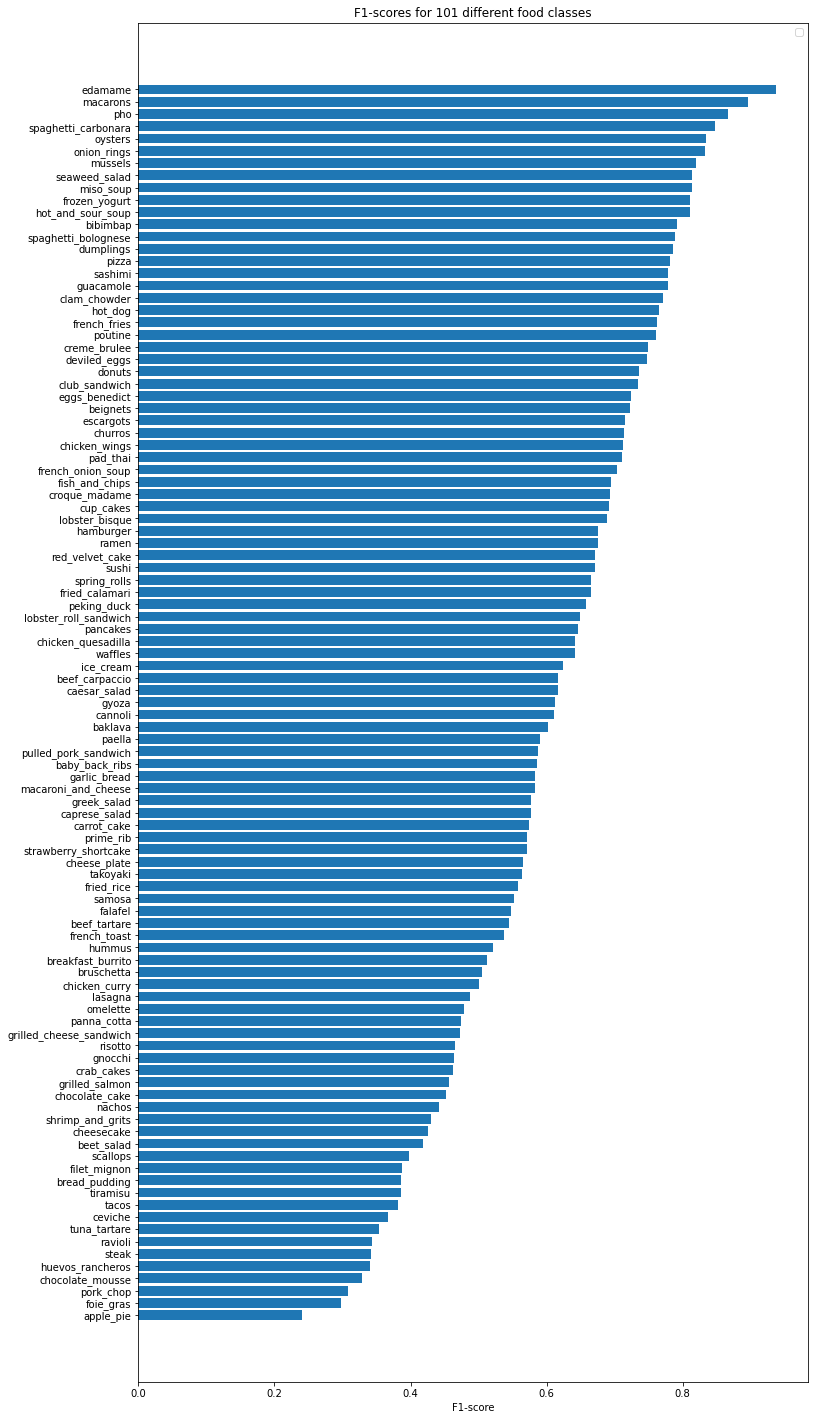

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes")
ax.invert_yaxis();
ax.legend()

## Visualizing predictions on custom images

How does our model go on food images not in our test dataset

In [78]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshape into
  specified shape

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Return:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale?
  if scale:
    # Rescale the image
    return img/255.
  else:
    return img
  

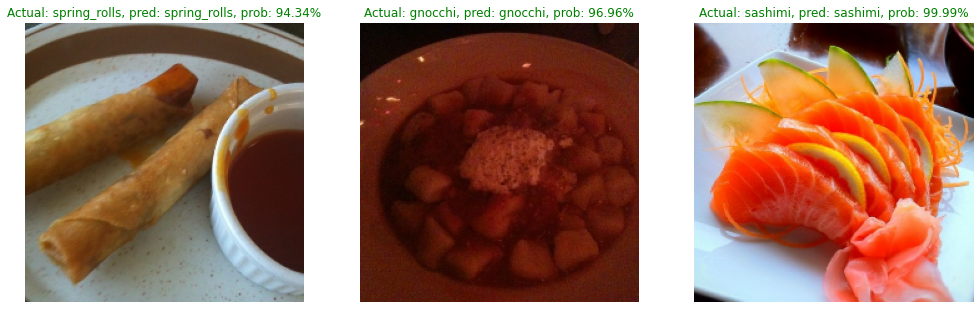

In [87]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random images from a random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  expanded_img = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(expanded_img)
  pred_class = class_names[pred_prob.argmax()]
  prob = round(tf.squeeze(pred_prob).numpy()[pred_prob.argmax()]*100, 2)
  # print(prob)
  # print(pred_class)
  
  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {prob}%", c=title_color)
  plt.axis(False)

## Finding the most wrong predictions

To find out where our model is most wrong, let's write som code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() methode
2. Create a pandas dataframe of the image filepaths, ground truth labels, predicted classes, max prediction probability
3. Use our dataframs to find all the wrong predictions
4. Sort the dataframe base on the wrong predictions
5. Visualize the images with the highest prediction probability but the wrong prediction

In [89]:
# Get all of the image file paths in the test dataset
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [90]:
# 2. Create a DatFrane of different parameters for each group of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

In [91]:
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878028,waffles,cheese_plate
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537899,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501950,waffles,strawberry_shortcake


In [92]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

In [93]:
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib,False
...,...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles,True
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878028,waffles,cheese_plate,False
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537899,waffles,waffles,True
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501950,waffles,strawberry_shortcake,False


In [113]:
# 4. Sort the dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False).reset_index()[:100]
top_100_wrong.iloc[0].img_path

b'/content/101_food_classes_10_percent/test/scallops/1784196.jpg'

In [130]:
# 5. Visualize the test data sample which have the wrong predictions but the highest pred probability

plt.figure(figsize=(100, 50))
for i in range(10, 19):
  # Load the image and make predictions
  filepath = top_100_wrong.iloc[i].img_path  
  img = load_and_prep_image(filepath, scale=False)
  pred_class = top_100_wrong.iloc[i].y_pred_classname
  prob = round(top_100_wrong.iloc[i].pred_conf*100, 2)

  class_name = top_100_wrong.iloc[i].y_true_classname
  # Plot the images
  plt.subplot(3, 3, i-9)
  plt.imshow(img/255.)
  

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {prob}%", c=title_color, fontdict = {'fontsize' : 50})
  plt.axis(False)

Output hidden; open in https://colab.research.google.com to view.

## Test our model on our own images

In [136]:
# Get custom images
!wget https://tastet.ca/wp-content/uploads/2021/04/dbe9be4a-pizza-bouquet-25.jpg


--2022-06-10 01:18:38--  https://tastet.ca/wp-content/uploads/2021/04/dbe9be4a-pizza-bouquet-25.jpg
Resolving tastet.ca (tastet.ca)... 104.26.3.227, 172.67.75.115, 104.26.2.227, ...
Connecting to tastet.ca (tastet.ca)|104.26.3.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173417 (169K) [image/jpeg]
Saving to: ‘dbe9be4a-pizza-bouquet-25.jpg.1’

dbe9be4a-pizza-bouq 100%[===================>] 169.35K  --.-KB/s    in 0.1s    

2022-06-10 01:18:39 (1.37 MB/s) - ‘dbe9be4a-pizza-bouquet-25.jpg.1’ saved [173417/173417]

--2022-06-10 01:18:39--  https://m1.quebecormedia.com/emp/cdp_prod/5ed34ff4a89d0c45be445f1819d28877940d9418/andraz-lazic-unsplash.jpg
Resolving m1.quebecormedia.com (m1.quebecormedia.com)... 23.62.65.62
Connecting to m1.quebecormedia.com (m1.quebecormedia.com)|23.62.65.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71438 (70K) [image/jpeg]
Saving to: ‘andraz-lazic-unsplash.jpg’

andraz-lazic-unspla 100%[=============

In [141]:
!wget https://www.cuisineactuelle.fr/imgre/fit/http.3A.2F.2Fprd2-bone-image.2Es3-website-eu-west-1.2Eamazonaws.2Ecom.2Fcac.2F2018.2F09.2F25.2F9612467b-35ac-4bba-87e4-98be0d6255d5.2Ejpeg/750x562/quality/80/crop-from/center/cr/wqkgIC8gQ3Vpc2luZSBBY3R1ZWxsZQ%3D%3D/royal-au-chocolat.jpeg

--2022-06-10 01:20:49--  https://www.cuisineactuelle.fr/imgre/fit/http.3A.2F.2Fprd2-bone-image.2Es3-website-eu-west-1.2Eamazonaws.2Ecom.2Fcac.2F2018.2F09.2F25.2F9612467b-35ac-4bba-87e4-98be0d6255d5.2Ejpeg/750x562/quality/80/crop-from/center/cr/wqkgIC8gQ3Vpc2luZSBBY3R1ZWxsZQ%3D%3D/royal-au-chocolat.jpeg
Resolving www.cuisineactuelle.fr (www.cuisineactuelle.fr)... 104.86.249.19
Connecting to www.cuisineactuelle.fr (www.cuisineactuelle.fr)|104.86.249.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55606 (54K) [image/jpeg]
Saving to: ‘royal-au-chocolat.jpeg’

royal-au-chocolat.j 100%[===================>]  54.30K  --.-KB/s    in 0.01s   

2022-06-10 01:20:49 (5.22 MB/s) - ‘royal-au-chocolat.jpeg’ saved [55606/55606]



(-0.5, 223.5, 223.5, -0.5)

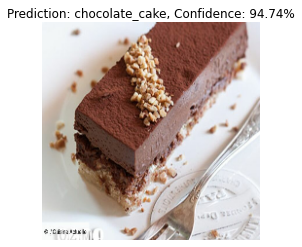

In [143]:
# Load the image and make predictions
img = load_and_prep_image("royal-au-chocolat.jpeg", scale=False)
expanded_img = tf.expand_dims(img, axis=0)
pred_prob = model.predict(expanded_img)
pred_class = class_names[pred_prob.argmax()]
prob = round(tf.squeeze(pred_prob).numpy()[pred_prob.argmax()]*100, 2)

# Plot the images
plt.imshow(img/255.)

plt.title(f"Prediction: {pred_class}, Confidence: {prob}%")
plt.axis(False)